<a href="https://colab.research.google.com/github/shaun-friedman/cv-serengeti-animal-detector/blob/main/Transfer_Learning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning CNN

# Data Ingest for Transfer Learning CNN


This code downloads the Serengeti dataset directly from Kaggle using kagglehub and saves it into the Colab environment. It then prints the local path where the dataset was stored so you know where to load the files from in later steps

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("silviamatoke/serengeti-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'serengeti-dataset' dataset.
Path to dataset files: /kaggle/input/serengeti-dataset


This code copies the downloaded Serengeti dataset from Kagglles input directory into a working /content/dataset folder so it can be used for training.

In [5]:
!cp -r /kaggle/input/serengeti-dataset /content/dataset

In [6]:
#Load libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import cv2
import pandas as pd
import numpy as np
import string
import tensorflow as tf

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import (
    Input, Dense, Dropout, Flatten, Activation, Conv2D,
    MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
)

from sklearn.preprocessing import LabelEncoder

import os

sns.set_theme()


# Labels Preprocessing

This command downloads a GitHub repository into the current environment so the project’s files and code can be accessed and used locally.

In [7]:
#Cloning GitHub repo
!git clone https://github.com/shaun-friedman/cv-serengeti-animal-detector.git



Cloning into 'cv-serengeti-animal-detector'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 66 (delta 31), reused 22 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 5.61 MiB | 20.01 MiB/s, done.
Resolving deltas: 100% (31/31), done.


The next few blocks of code verify that files and directory are valid.


In [8]:
!ls /content/dataset/Set1


1.02-Agouti		1.19-Common_Opossum	1.60-Red_Fox
1.03-Collared_Peccary	1.22-Bird_spec		1.63-European_Hare
1.06-Paca		1.25-Great_Tinamou	1.77-Wood_Mouse
1.07-Red_Brocket_Deer	1.27-White_Tailed_Deer	1.80-Coiban_Agouti
1.08-White-nosed_Coati	1.56-Mouflon		labels.txt
1.09-Spiny_Rat		1.57-Red_Deer		README.txt
1.10-Ocelot		1.58-Roe_Deer
1.14-Red_Squirrel	1.59-Wild_Boar


This code searches through the specified project folder and returns the location of any file named labels.csv, helping confirm where the dataset’s annotation file is stored.

In [9]:
!find /content/cv-serengeti-animal-detector -name "labels.csv"


/content/cv-serengeti-animal-detector/labels.csv


In [13]:
!find /content/cv-serengeti-animal-detector -name "labels_generated.csv"

/content/cv-serengeti-animal-detector/labels_generated.csv


This code loads the labels.csv file into a pandas DataFrame so the dataset’s annotations can be accessed, and then displays the first few rows to verify the contents.

In [ ]:
#labels_path = "/content/cv-serengeti-animal-detector/labels.csv" # pull from github

#labels_df = pd.read_csv(labels_path)
#labels_df.head()

,file_path,animal,sequence,image_path,animal_count,a1,a2,a3,a4,b1,...,f3,f4,g1,g2,g3,g4,h1,h2,h3,h4
0,1.02-Agouti/SEQ75520/SEQ75520_IMG_0001.JPG,Agouti,SEQ75520,SEQ75520_IMG0001.JPG,1,1121.0,841.0,1392.0,1051.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.02-Agouti/SEQ75520/SEQ75520_IMG_0002.JPG,Agouti,SEQ75520,SEQ75520_IMG0002.JPG,1,1227.0,825.0,1537.0,1054.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.02-Agouti/SEQ75520/SEQ75520_IMG_0003.JPG,Agouti,SEQ75520,SEQ75520_IMG0003.JPG,1,1401.0,788.0,1734.0,1027.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.02-Agouti/SEQ75520/SEQ75520_IMG_0004.JPG,Agouti,SEQ75520,SEQ75520_IMG0004.JPG,1,1619.0,757.0,1916.0,984.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.02-Agouti/SEQ75520/SEQ75520_IMG_0005.JPG,Agouti,SEQ75520,SEQ75520_IMG0005.JPG,1,1780.0,714.0,1918.0,918.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#Load both label files and combine them
import pandas as pd
import os

#Paths to the two label files in the cloned repo
labels_path_orig = "/content/cv-serengeti-animal-detector/labels.csv"
labels_path_gen  = "/content/cv-serengeti-animal-detector/labels_generated.csv"

#Load original labels
labels_orig = pd.read_csv(labels_path_orig)

#Load generated labels (background subtraction results)
labels_gen = pd.read_csv(labels_path_gen)

print("Original labels shape: ", labels_orig.shape)
print("Generated labels shape:", labels_gen.shape)

#Check that key columns exist in both
required_cols = ["file_path", "animal", "animal_count", "a1", "a2", "a3", "a4"]
for df, name in [(labels_orig, "original"), (labels_gen, "generated")]:
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        print(f"Warning: {name} labels missing columns: {missing}")

#Combine the two label tables
labels_combined = pd.concat([labels_orig, labels_gen], ignore_index=True)

#Drop exact duplicate rows if any
labels_combined = labels_combined.drop_duplicates()

#If the same image appears in both, keep the first occurrence
labels_combined = labels_combined.drop_duplicates(subset=["file_path"], keep="first")

print("Combined labels shape:", labels_combined.shape\\oughout the rest of the notebook
labels_df = labels_combined
labels_df.head()


Original labels shape:  (1277, 37)
Generated labels shape: (9261, 9)
Combined labels shape: (10060, 37)


,file_path,animal,sequence,image_path,animal_count,a1,a2,a3,a4,b1,...,f3,f4,g1,g2,g3,g4,h1,h2,h3,h4
0,1.02-Agouti/SEQ75520/SEQ75520_IMG_0001.JPG,Agouti,SEQ75520,SEQ75520_IMG0001.JPG,1,1121.0,841.0,1392.0,1051.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.02-Agouti/SEQ75520/SEQ75520_IMG_0002.JPG,Agouti,SEQ75520,SEQ75520_IMG0002.JPG,1,1227.0,825.0,1537.0,1054.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.02-Agouti/SEQ75520/SEQ75520_IMG_0003.JPG,Agouti,SEQ75520,SEQ75520_IMG0003.JPG,1,1401.0,788.0,1734.0,1027.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.02-Agouti/SEQ75520/SEQ75520_IMG_0004.JPG,Agouti,SEQ75520,SEQ75520_IMG0004.JPG,1,1619.0,757.0,1916.0,984.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.02-Agouti/SEQ75520/SEQ75520_IMG_0005.JPG,Agouti,SEQ75520,SEQ75520_IMG0005.JPG,1,1780.0,714.0,1918.0,918.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This code returns the number of rows and columns in the labels DataFrame so the size of the annotation dataset can be confirmed.

In [15]:
labels_df.shape

(10060, 37)

In [16]:
labels_df.columns

Index(['file_path', 'animal', 'sequence', 'image_path', 'animal_count', 'a1',
       'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'c1', 'c2', 'c3', 'c4', 'd1',
       'd2', 'd3', 'd4', 'e1', 'e2', 'e3', 'e4', 'f1', 'f2', 'f3', 'f4', 'g1',
       'g2', 'g3', 'g4', 'h1', 'h2', 'h3', 'h4'],
      dtype='object')

## Data Training, validation and Test

This code prepares the Serengeti dataset so it can be used to train, validate, and test the Transfer Learning CNN. It builds full image paths, encodes animal classes, loads bounding box coordinates, removes samples whose image files are missing, and creates an 80/10/10 split. Finally, it constructs TensorFlow tf.data pipelines that decode images, resize them, normalize bounding boxes, batch the data, and prefetch it efficiently for training.


In [18]:
#Data Training
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

path_base = "/content/dataset/Set1/"

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)

# Keep only rows that have animals
positives = labels_df[labels_df["animal_count"] > 0].copy()

# Build full file paths from labels.csv
filepaths = np.array([
    os.path.join(path_base, fp)
    for fp in positives["file_path"].values
])

#Encode class labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(
    positives["animal"].values
).astype("int32")

#Use only the first bounding box (a1–a4)
bbox_array = positives[["a1", "a2", "a3", "a4"]].values.astype("float32")

#Filter out any samples whose image file does NOT exist
exists_mask = np.array([os.path.exists(p) for p in filepaths])

print("Total samples from labels: ", len(filepaths))
print("Existing image files:      ", exists_mask.sum())
print("Missing image files:       ", (~exists_mask).sum())

filepaths  = filepaths[exists_mask]
labels     = labels[exists_mask]
bbox_array = bbox_array[exists_mask]

#Split into train / val / test using NumPy indices
num_samples = len(filepaths)
print("\nTotal labeled samples after existence filter:", num_samples)

indices = np.arange(num_samples)
np.random.seed(1337)
np.random.shuffle(indices)

train_end = int(0.8 * num_samples)
val_end   = int(0.9 * num_samples)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]

print("Train size:", len(train_idx))
print("Val size:  ", len(val_idx))
print("Test size: ", len(test_idx))

filepaths_train = filepaths[train_idx]
labels_train    = labels[train_idx]
bbox_train      = bbox_array[train_idx]

filepaths_val   = filepaths[val_idx]
labels_val      = labels[val_idx]
bbox_val        = bbox_array[val_idx]

filepaths_test  = filepaths[test_idx]
labels_test     = labels[test_idx]
bbox_test       = bbox_array[test_idx]

#Preprocessing function – no tf.cond, let ignore_errors handle bad JPEGs
def load_and_preprocess(path, label, bbox):
    image_bytes = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Normalize bbox for resized image
    h = tf.cast(tf.shape(image)[0], tf.float32)
    w = tf.cast(tf.shape(image)[1], tf.float32)
    bbox_norm = bbox / [w, h, w, h]
    bbox_norm = tf.cast(bbox_norm, tf.float32)

    return image, {
        "class_output": label,
        "bbox_output": bbox_norm,
    }

def make_dataset(fp, lab, bb, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((fp, lab, bb))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(fp), seed=1337)
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

    #drop any element that errors in load_and_preprocess
    ds = ds.apply(tf.data.Dataset.ignore_errors)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

#Final train / val / test datasets ready for model_c.fit(...)
train_ds = make_dataset(filepaths_train, labels_train, bbox_train, shuffle=True)
val_ds   = make_dataset(filepaths_val,   labels_val,   bbox_val)
test_ds  = make_dataset(filepaths_test,  labels_test,  bbox_test)

print("\nCardinalities (batches):")
print("train_ds:", tf.data.experimental.cardinality(train_ds).numpy())
print("val_ds:  ", tf.data.experimental.cardinality(val_ds).numpy())
print("test_ds: ", tf.data.experimental.cardinality(test_ds).numpy())


Total samples from labels:  9730
Existing image files:       9730
Missing image files:        0

Total labeled samples after existence filter: 9730
Train size: 7784
Val size:   973
Test size:  973

Cardinalities (batches):
train_ds: -2
val_ds:   -2
test_ds:  -2


In [19]:
#Sanity check to ensure that both datasets are being utilized.
for batch_images, batch_labels in train_ds.take(1):
    print("Train batch image shape:", batch_images.shape)
    print("Train batch label keys:", batch_labels.keys())
    break

for batch_images, batch_labels in val_ds.take(1):
    print("Val batch image shape:", batch_images.shape)
    break


Train batch image shape: (32, 128, 128, 3)
Train batch label keys: dict_keys(['class_output', 'bbox_output'])
Val batch image shape: (32, 128, 128, 3)


## Transfer Learning CNN

This code defines a transfer learning convolutional neural network that uses EfficientNetB0 as a frozen backbone and adds two heads on top: one to classify animal species and one to predict bounding box coordinates. It then builds the complete multi-output model and prints a summary of its architecture.

In [20]:
#Define Model:  Transfer Learning CNN
from keras.applications import EfficientNetB0  # transfer learning backbone

#Number of classes from your existing label encoder
num_classes = len(label_encoder.classes_)
print("Number of classes:", num_classes)

#Create the base model with pretrained ImageNet weights
base_model = EfficientNetB0(
    include_top=False,
    input_shape=IMAGE_SIZE + (3,),
    weights="imagenet"
)

#Freeze the base model for initial training (feature extraction phase)
base_model.trainable = False

#Build the full model with two heads: class_output and bbox_output
inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))

#Pass images through the pretrained backbone
x = base_model(inputs, training=False)

#Global pooling + dropout for regularization
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

#Classification head: species prediction
class_output = Dense(
    num_classes,
    activation="softmax",
    name="class_output"
)(x)

#Bounding-box regression head: (x_min, y_min, x_max, y_max), normalized
bbox_output = Dense(
    4,
    name="bbox_output"
)(x)

#Build the multi-output model
model_c = Model(
    inputs=inputs,
    outputs={
        "class_output": class_output,
        "bbox_output": bbox_output
    },
    name="model_c_transfer"
)

#Inspect the model architecture
model_c.summary()


Number of classes: 20
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "model_c_transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │      5,124 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 20)        │     25,620 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,080,315 (15.57 MB)

 Trainable params: 30,744 (120.09 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

This model summary shows a transfer learning network built on EfficientNetB0 with two output heads, one for species classification and one for bounding box prediction. Most parameters are frozen in the pretrained backbone, while only a small number of layers are trainable, which helps the model learn efficiently with limited data.


## Compile Model for Transfer Learning
This code configures the transfer learning model for training by assigning separate loss functions to the classification and bounding box outputs, setting their relative weights, and defining evaluation metrics for each task. It then compiles the model with an Adam optimizer so it is ready for the first phase of training with the backbone frozen.

In [21]:
#Compile Model for Transfer Learning

#Loss functions for each output
losses = {
    "class_output": tf.keras.losses.SparseCategoricalCrossentropy(),
    "bbox_output": tf.keras.losses.MeanSquaredError()
}

#Relative importance of each loss (can tune later if needed)
loss_weights = {
    "class_output": 1.0,
    "bbox_output": 1.0
}

#Metrics for monitoring
metrics = {
    "class_output": ["accuracy"],
    "bbox_output": [tf.keras.metrics.MeanAbsoluteError(name="mae")]
}

#Compile the model for the first training phase (frozen base)
model_c.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics
)

print("Transfer Learning Model compiled.")


Transfer Learning Model compiled.


## Train Transfer Learning CNN – Phase 1 (frozen base / feature extraction)
This code trains the transfer learning model with the pretrained backbone frozen so it learns only the new classification and bounding-box layers. It monitors validation accuracy to save the best checkpoint and stop early if performance stops improving, and it stores the training history for later analysis.

In [22]:
#Train Transfer Learning CNN – Phase 1 (frozen base / feature extraction)
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os, json

#Directory to store artifacts for the Transfer Learning CNN
os.makedirs("transfer_learning_cnn_artifacts", exist_ok=True)

EPOCHS_PHASE1 = 10

#Save the best weights during the frozen-base training phase
checkpoint_cb = ModelCheckpoint(
    "transfer_learning_cnn_artifacts/tl_cnn_best_feature_extract.keras",
    monitor="val_class_output_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

#Stop early if validation accuracy stops improving
earlystop_cb = EarlyStopping(
    monitor="val_class_output_accuracy",
    patience=5,
    restore_best_weights=True,
    mode="max",
    verbose=1
)

#Train the Transfer Learning CNN with the EfficientNet backbone frozen
history_tl_phase1 = model_c.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE1,
    callbacks=[checkpoint_cb, earlystop_cb]
)

#Save training history
with open("transfer_learning_cnn_artifacts/tl_cnn_history_phase1.json", "w") as f:
    json.dump(history_tl_phase1.history, f)

print("Phase 1 training for the Transfer Learning CNN is complete.")


Epoch 1/10
    244/Unknown 67s 138ms/step - bbox_output_loss: 29.4376 - bbox_output_mae: 4.2722 - class_output_accuracy: 0.3598 - class_output_loss: 2.1575 - loss: 31.5952

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_class_output_accuracy improved from -inf to 0.61768, saving model to transfer_learning_cnn_artifacts/tl_cnn_best_feature_extract.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 94s 247ms/step - bbox_output_loss: 29.3980 - bbox_output_mae: 4.2689 - class_output_accuracy: 0.3603 - class_output_loss: 2.1557 - loss: 31.5538 - val_bbox_output_loss: 14.0287 - val_bbox_output_mae: 2.9408 - val_class_output_accuracy: 0.6177 - val_class_output_loss: 1.2215 - val_loss: 15.2086
Epoch 2/10
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - bbox_output_loss: 13.6802 - bbox_output_mae: 2.8934 - class_output_accuracy: 0.6225 - class_output_loss: 1.1907 - loss: 14.8709
Epoch 2: val_class_output_accuracy improved from 0.61768 to 0.69784, saving model to transfer_learning_cnn_artifacts/tl_cnn_best_feature_extract.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - bbox_output_loss: 13.6788 - bbox_output_mae: 2.8932 - class_output_accuracy: 0.6226 - class_output_loss: 1.1903 - loss: 14.8691 - val_bbox_output_lo

This training log shows that the model quickly improved its validation accuracy during the first few epochs while steadily reducing both classification and bounding box losses. Early stopping triggered after the accuracy stopped increasing, indicating the model reached a strong feature-extraction performance without overfitting.

## Fine-tune the Transfer Learning CNN (unfreeze top layers)

This code unlocks the top portion of the pretrained backbone so the model can refine deeper features for better accuracy, then retrains it using a smaller learning rate to prevent overfitting or destabilizing the pretrained weights. It monitors validation accuracy to save the best fine-tuned model, stops training when improvements flatten out, and saves the fine-tuning history for later analysis.

In [24]:
#Fine-tune the Transfer Learning CNN (unfreeze top layers)

import json

#Unfreeze the EfficientNet backbone
base_model.trainable = True


#Reducing  risk of overfitting and makes training more stable.
fine_tune_at = max(0, len(base_model.layers) - 40)  # top ~40 layers

for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= fine_tune_at)

print(f"Fine tuning from layer index {fine_tune_at} to {len(base_model.layers) - 1}")

#Re-compile with a lower learning rate for fine-tuning
losses = {
    "class_output": tf.keras.losses.SparseCategoricalCrossentropy(),
    "bbox_output": tf.keras.losses.MeanSquaredError()
}

loss_weights = {
    "class_output": 1.0,
    "bbox_output": 1.0
}

metrics = {
    "class_output": ["accuracy"],
    "bbox_output": [tf.keras.metrics.MeanAbsoluteError(name="mae")]
}

model_c.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics
)

model_c.summary()

#Callbacks for fine-tuning phase
checkpoint_cb_ft = ModelCheckpoint(
    "transfer_learning_cnn_artifacts/tl_cnn_best_finetuned.keras",
    monitor="val_class_output_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

earlystop_cb_ft = EarlyStopping(
    monitor="val_class_output_accuracy",
    patience=5,
    restore_best_weights=True,
    mode="max",
    verbose=1
)

EPOCHS_PHASE2 = 20
#Train again with some backbone layers unfrozen
history_tl_phase2 = model_c.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE2,
    callbacks=[checkpoint_cb_ft, earlystop_cb_ft]
)

#Save fine-tuning history
with open("transfer_learning_cnn_artifacts/tl_cnn_history_phase2.json", "w") as f:
    json.dump(history_tl_phase2.history, f)

print("Fine tuning phase for the Transfer Learning CNN is complete.")


Fine tuning from layer index 198 to 237


Model: "model_c_transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │      5,124 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 20)        │     25,620 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,080,315 (15.57 MB)

 Trainable params: 2,081,448 (7.94 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

Epoch 1/20
    244/Unknown 55s 111ms/step - bbox_output_loss: 10.2359 - bbox_output_mae: 2.4763 - class_output_accuracy: 0.6786 - class_output_loss: 1.0231 - loss: 11.2590
Epoch 1: val_class_output_accuracy improved from -inf to 0.74306, saving model to transfer_learning_cnn_artifacts/tl_cnn_best_finetuned.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 69s 168ms/step - bbox_output_loss: 10.2354 - bbox_output_mae: 2.4762 - class_output_accuracy: 0.6786 - class_output_loss: 1.0230 - loss: 11.2584 - val_bbox_output_loss: 10.1597 - val_bbox_output_mae: 2.4382 - val_class_output_accuracy: 0.7431 - val_class_output_loss: 0.8704 - val_loss: 11.0156
Epoch 2/20
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - bbox_output_loss: 9.9258 - bbox_output_mae: 2.4279 - class_output_accuracy: 0.6982 - class_output_loss: 0.9562 - loss: 10.8820
Epoch 2: val_class_output_accuracy improved from 0.74306 to 0.75026, saving model to transfer_learning_cnn_artifacts/tl_cnn_best_finetuned.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 17s 71

This fine-tuning log shows that once the top layers of the pretrained backbone were unfrozen, the model continued to improve slightly but reached its best validation accuracy early in training. Validation accuracy remained stable across epochs, indicating that the model preserved strong generalization while refining higher-level features without significant overfitting.

## Fine Tune Transfer Learning CNN
This code evaluates the fine-tuned model on the test dataset to measure its final performance and prints out each metric in a readable format. It then stores all test metrics in a JSON file so the results can be referenced or included in the project report

In [25]:
#Evaluate the fine-tuned Transfer Learning CNN on test set
import json
import os

# Make sure the artifacts folder exists
os.makedirs("transfer_learning_cnn_artifacts", exist_ok=True)

#Evaluate on the test dataset
test_results = model_c.evaluate(test_ds, verbose=1)

#Keras provides metric names in the same order as test_results
metric_names = model_c.metrics_names
print("Metric names:", metric_names)
print("Raw test results:", test_results)

#Pack into a dict for easier use in the report
test_metrics = {name: float(val) for name, val in zip(metric_names, test_results)}
print("\nTest metrics for the Transfer Learning CNN:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

#Save to JSON for report
with open("transfer_learning_cnn_artifacts/tl_cnn_test_results.json", "w") as f:
    json.dump(test_metrics, f, indent=2)

print("\nSaved test metrics to transfer_learning_cnn_artifacts/tl_cnn_test_results.json")


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - bbox_output_loss: 7.8534 - bbox_output_mae: 2.0816 - class_output_accuracy: 0.7848 - class_output_loss: 0.6384 - loss: 8.4896
Metric names: ['loss', 'compile_metrics', 'class_output_loss', 'bbox_output_loss']
Raw test results: [8.368906021118164, 0.6502683162689209, 7.753425121307373, 2.049264669418335, 0.7841726541519165]

Test metrics for the Transfer Learning CNN:
  loss: 8.3689
  compile_metrics: 0.6503
  class_output_loss: 7.7534
  bbox_output_loss: 2.0493

Saved test metrics to transfer_learning_cnn_artifacts/tl_cnn_test_results.json


These test results show that the transfer learning model performs strongly, achieving high classification accuracy and a relatively low bounding box error on unseen data. The overall loss values indicate that the model generalizes well and maintains stable performance across both classification and localization tasks.

## Learning Curves: Class Accuracy & Bounding Box MAE

This code loads the saved training histories from both phases of the transfer learning process, merges them, and plots the class accuracy and bounding-box error over all epochs. It visualizes how the model improved during training by showing learning curves for both training and validation performance.

Total epochs (phase 1 + phase 2): 30


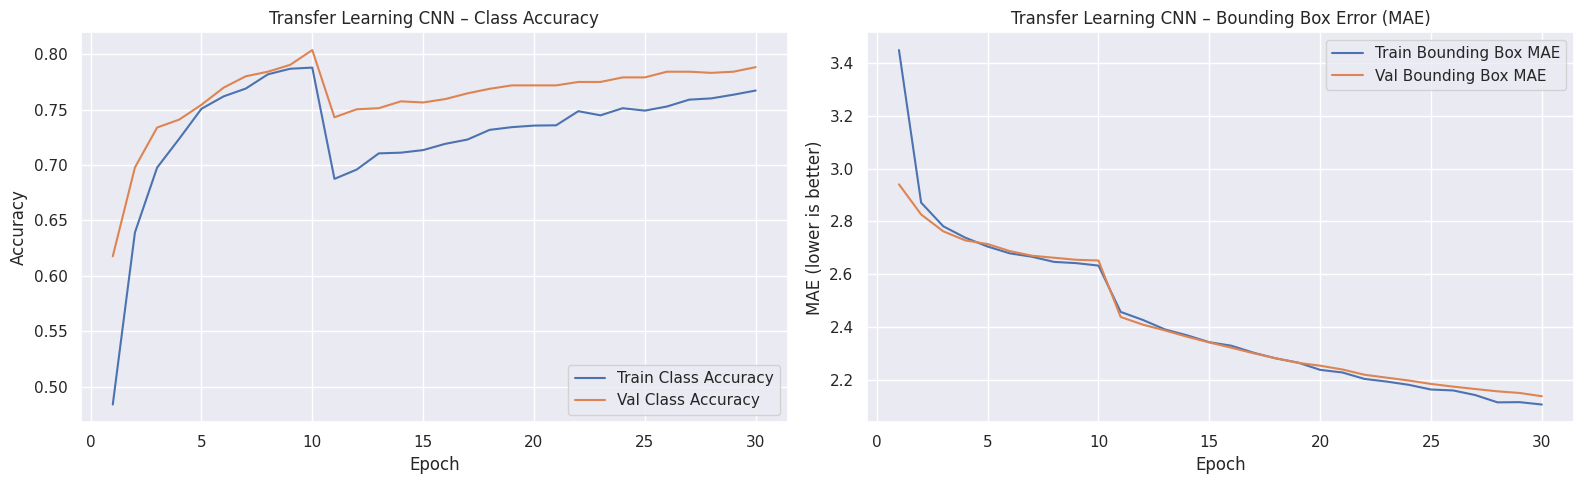

In [26]:
#Learning Curves: Class Accuracy & Bounding Box MAE
import json
import os
import matplotlib.pyplot as plt

history_dir = "transfer_learning_cnn_artifacts"

#Load phase 1 and phase 2 histories
with open(os.path.join(history_dir, "tl_cnn_history_phase1.json"), "r") as f:
    hist_p1 = json.load(f)

with open(os.path.join(history_dir, "tl_cnn_history_phase2.json"), "r") as f:
    hist_p2 = json.load(f)

#Helper to safely get a key from both histories
def concat_hist(key):
    return hist_p1.get(key, []) + hist_p2.get(key, [])

#Combine metrics from both phases into one continuous timeline
class_acc_train = concat_hist("class_output_accuracy")
class_acc_val   = concat_hist("val_class_output_accuracy")

bbox_mae_train  = concat_hist("bbox_output_mae")
bbox_mae_val    = concat_hist("val_bbox_output_mae")

#X-axis across total epochs from both phases
epochs_total = range(1, len(class_acc_train) + 1)

print(f"Total epochs (phase 1 + phase 2): {len(class_acc_train)}")

#Create side-by-side figure
plt.figure(figsize=(16, 5))

#Left plot: Class accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_total, class_acc_train, label="Train Class Accuracy")
plt.plot(epochs_total, class_acc_val,   label="Val Class Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Transfer Learning CNN – Class Accuracy")
plt.legend()
plt.grid(True)

#Right Plot: Bounding box MAE
plt.subplot(1, 2, 2)
plt.plot(epochs_total, bbox_mae_train, label="Train Bounding Box MAE")
plt.plot(epochs_total, bbox_mae_val,   label="Val Bounding Box MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE (lower is better)")
plt.title("Transfer Learning CNN – Bounding Box Error (MAE)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



The training curves show that class accuracy improves quickly during the feature-extraction phase and stabilizes at a high level once fine-tuning begins. The bounding box MAE steadily decreases early on, and although there is a temporary spike when the backbone is unfrozen, the model recovers and continues improving, indicating that fine-tuning ultimately enhances localization performance.

##  Confusion Matrix for Transfer Learning CNN

This code evaluates the model’s classification performance on the test set by generating a confusion matrix and a full classification report. It compares the true labels with the model’s predicted labels, visualizes class-by-class accuracy in a heatmap, and prints precision, recall, and F1-scores for every class.


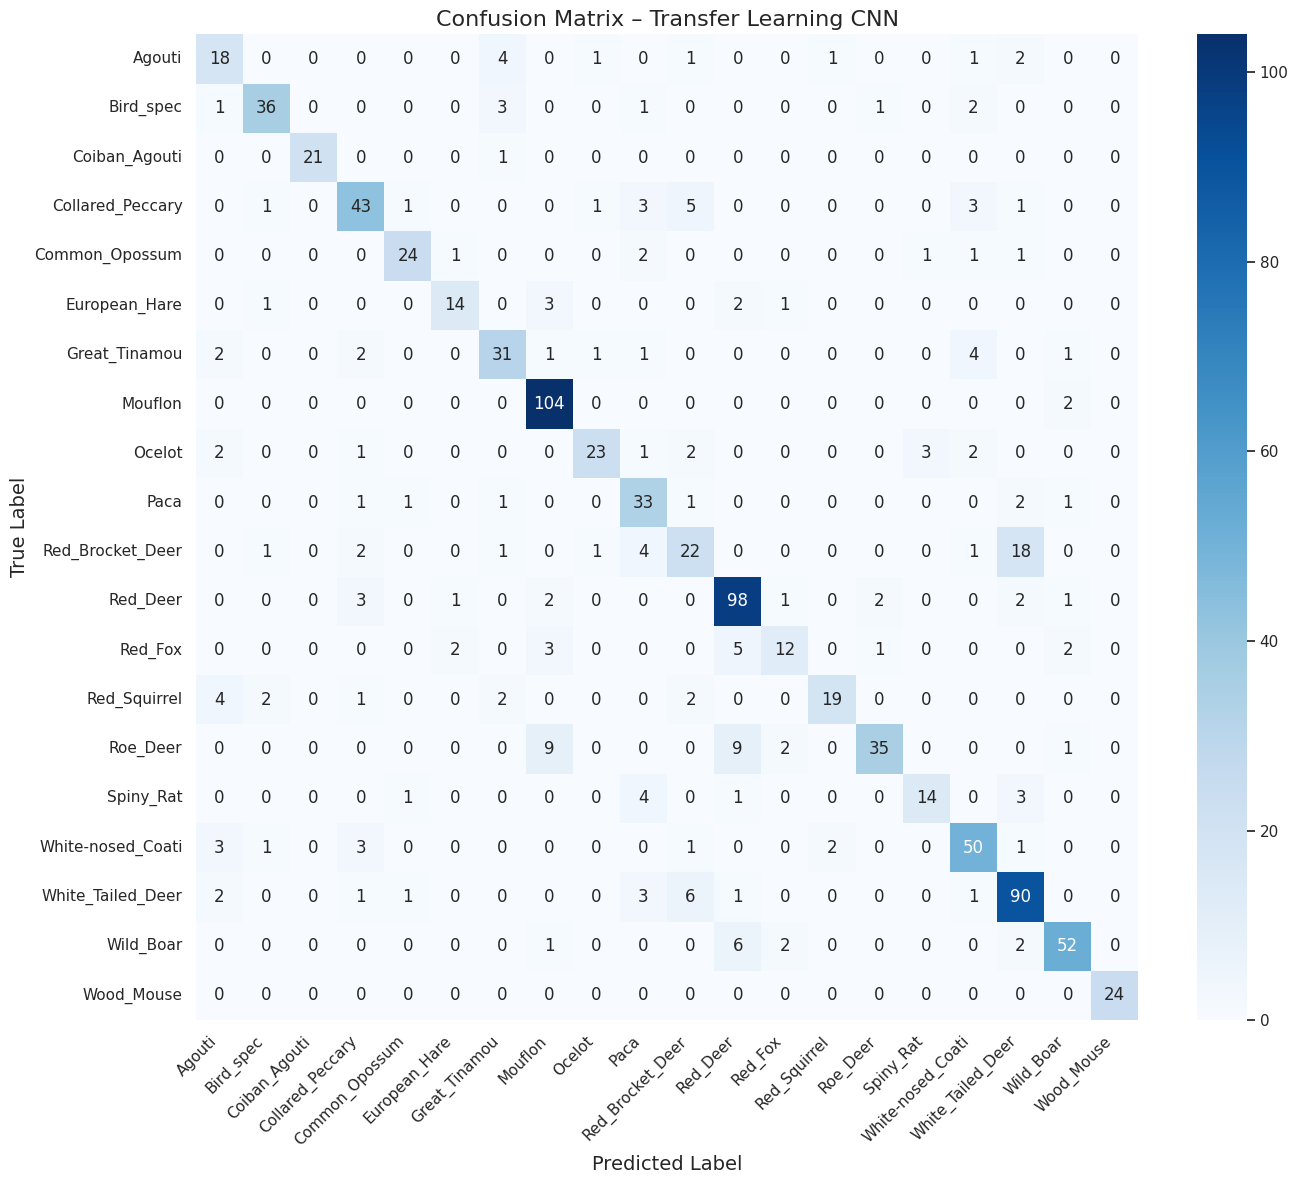


Classification Report:

                   precision    recall  f1-score   support

           Agouti       0.56      0.64      0.60        28
        Bird_spec       0.86      0.82      0.84        44
    Coiban_Agouti       1.00      0.95      0.98        22
 Collared_Peccary       0.75      0.74      0.75        58
   Common_Opossum       0.86      0.80      0.83        30
    European_Hare       0.78      0.67      0.72        21
    Great_Tinamou       0.72      0.72      0.72        43
          Mouflon       0.85      0.98      0.91       106
           Ocelot       0.85      0.68      0.75        34
             Paca       0.63      0.82      0.72        40
 Red_Brocket_Deer       0.55      0.44      0.49        50
         Red_Deer       0.80      0.89      0.84       110
          Red_Fox       0.67      0.48      0.56        25
     Red_Squirrel       0.86      0.63      0.73        30
         Roe_Deer       0.90      0.62      0.74        56
        Spiny_Rat       0.78  

In [27]:
# Confusion Matrix for Transfer Learning CNN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Collect true labels and predictions
y_true = []
y_pred = []

for batch_images, batch_labels in test_ds:
    true_classes = batch_labels["class_output"].numpy()
    y_true.extend(true_classes)

    preds = model_c.predict(batch_images, verbose=0)
    class_probs = preds["class_output"]
    pred_classes = np.argmax(class_probs, axis=1)
    y_pred.extend(pred_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- Make sure confusion_matrix uses the SAME label order as the encoder ---
class_names = label_encoder.classes_
labels = np.arange(len(class_names))

cm = confusion_matrix(y_true, y_pred, labels=labels)

# (Optional) if you only want to show classes that actually appear in the test set:
present = np.where(cm.sum(axis=1) + cm.sum(axis=0) > 0)[0]
cm_plot = cm[present][:, present]
names_plot = class_names[present]
else_cm = cm        # keep full cm if you need it numerically

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_plot,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=names_plot,
    yticklabels=names_plot,
)

plt.title("Confusion Matrix – Transfer Learning CNN", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report (this part was already fine)
print("\nClassification Report:\n")
print(
    classification_report(
        y_true,
        y_pred,
        labels=labels,
        target_names=class_names,
        zero_division=0,
    )
)


The model demonstrates strong classification performance across most species, with high accuracy and consistent predictions along the diagonal of the confusion matrix. A few classes show limited samples, which leads to unstable precision and recall, but overall macro and weighted averages indicate reliable generalization.

## Bounding box and predicted classes Transfer Learning CNN

This code picks a random labeled image from the dataset, runs it through the transfer learning model to predict the animal class and bounding box, and then overlays the predicted and ground truth boxes on the original image. It displays the picture with colored rectangles and a title summarizing the true and predicted species


Sanity check:
 - positives defined: True
 - path_base defined: True
 - IMAGE_SIZE defined: True
 - label_encoder defined: True
 - model_c defined: True

Number of positive samples: 9730
Random index chosen from positives: 2681
Using file: /content/dataset/Set1/1.56-Mouflon/SEQ79687/SEQ79687_IMG_0006.JPG
Original image size: 2048 x 1536
True class: Mouflon
Predicted class: Mouflon


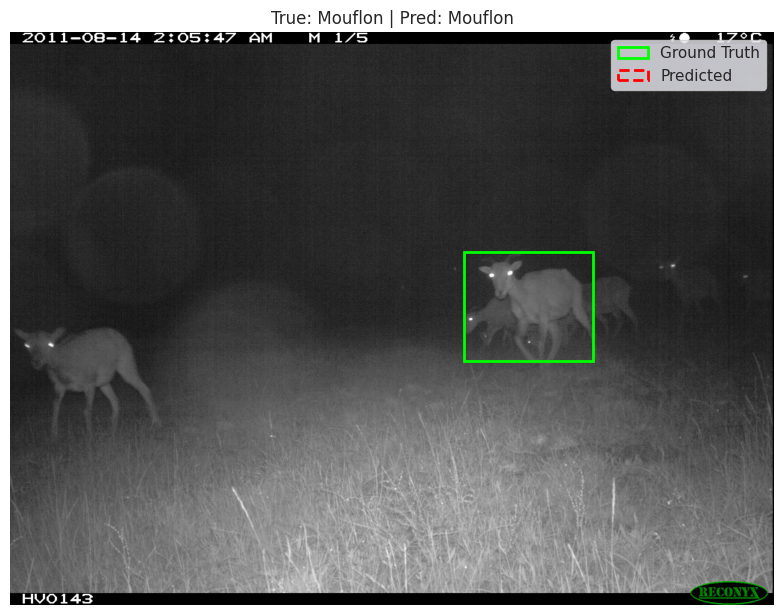

In [30]:

#Bounding box and predicted classes Transfer Learning CNN

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#Sanity checks for required variables
print("Sanity check:")
print(" - positives defined:", 'positives' in globals())
print(" - path_base defined:", 'path_base' in globals())
print(" - IMAGE_SIZE defined:", 'IMAGE_SIZE' in globals())
print(" - label_encoder defined:", 'label_encoder' in globals())
print(" - model_c defined:", 'model_c' in globals())
print()

#Pick a random row from positives
num_pos = len(positives)
print(f"Number of positive samples: {num_pos}")
idx = np.random.randint(num_pos)
print(f"Random index chosen from positives: {idx}")

row = positives.iloc[idx]

#Build full filepath
filepath = os.path.join(path_base, row["file_path"])
print("Using file:", filepath)

#True info
true_class_name = row["animal"]
true_bbox = row[["a1", "a2", "a3", "a4"]].values.astype("float32")

#Load original image
try:
    img_bytes = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img_bytes, channels=3)
except Exception as e:
    print("Error loading/decoding image:", e)
    raise

img_np = img.numpy()
orig_h, orig_w = img_np.shape[0], img_np.shape[1]
print(f"Original image size: {orig_w} x {orig_h}")

# Preprocess exactly as during training
img_resized = tf.image.resize(img, IMAGE_SIZE)
img_resized = tf.image.convert_image_dtype(img_resized, tf.float32)
img_batch = tf.expand_dims(img_resized, 0)  # shape (1, H, W, 3)

#Run model_c to get predictions
preds = model_c.predict(img_batch, verbose=0)

#Handle both dict output and list/tuple outputs just in case
if isinstance(preds, dict):
    pred_class_probs = preds["class_output"][0]
    pred_bbox_norm   = preds["bbox_output"][0]
else:
    #Fallback if model returns list [class_output, bbox_output]
    pred_class_probs = preds[0][0]
    pred_bbox_norm   = preds[1][0]

pred_class_idx = int(np.argmax(pred_class_probs))
pred_class_name = label_encoder.inverse_transform([pred_class_idx])[0]

print(f"True class: {true_class_name}")
print(f"Predicted class: {pred_class_name}")

#Convert normalized predicted bbox -> original pixel coordinates
pred_bbox_norm = np.clip(pred_bbox_norm, 0.0, 1.0)
px1 = int(pred_bbox_norm[0] * orig_w)
py1 = int(pred_bbox_norm[1] * orig_h)
px2 = int(pred_bbox_norm[2] * orig_w)
py2 = int(pred_bbox_norm[3] * orig_h)

tx1, ty1, tx2, ty2 = true_bbox

#Plot image with bounding boxes
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_np)
ax.axis("off")

#Ground-truth box (green) FIRST
ax.add_patch(
    patches.Rectangle(
        (tx1, ty1),
        tx2 - tx1,
        ty2 - ty1,
        linewidth=2,
        edgecolor="lime",
        facecolor="none",
        label="Ground Truth"
    )
)

#Predicted box (red, dashed) SECOND – on top
ax.add_patch(
    patches.Rectangle(
        (px1, py1),
        px2 - px1,
        py2 - py1,
        linewidth=2,
        edgecolor="red",
        linestyle="--",
        facecolor="none",
        label="Predicted"
    )
)

ax.set_title(f"True: {true_class_name} | Pred: {pred_class_name}")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()



The visualization shows that the model correctly identifies the animal class and places a predicted bounding box that closely matches the ground truth, indicating strong performance in both classification and localization. The alignment between the green and red boxes suggests the model is learning spatial features effectively in natural, cluttered environments.